## Instruction Parse
Author: Riordan Callil

I wrote some pretty notes this morning detailing the entire problem I am facing in my honours. 
I have been operating under the CHALLENGE that I will only consider my robot immediate surroundings. This is silly and playing the game harder than it needs to be played. Instead of considering the embodiment of my robot I am going to activly ignore it. Niko's paper used the entire graph and like a convolutional layer, produced an activation map, (or activation graph in this case), of the entire graph. The graph had its features smoothed by the graph convolutional network then an idividual nodes activation is produced by feeding the target landmark and the nodes convolved feature to a fully connected network. 

I confused myself and complicated the problem by actually making the problem "smaller". Really, I just made the problem harder by making the robot blind despite access to a full map. So Im going back, to reconsider my assumptions. 

The problem can be described in a sentence: <b>"Given a block of text, follow instructions".</b>
This introduces many design choices I'll now break down:
"Given a block of text"
--------------------------
- Can contain multiple instructions / Can contain a single instruction
- Instructions meant to be followed sequentially / Instructions meant to be followed in any order
- Multiple instructions per sentence / Single instruction per sentence

"follow instructions"
---------------------
- Meaning: Produce the instruction output.
- Execute all instrutions
- NOT taking any shortcuts. The instructions are like constraints for following a path of actions, If I describe a method for making coffee at home, I dont want my robot to go buy coffee. 

Best outcome (Realistic instructions)
-----------------
"Given a block of text containing <b>multiple</b> instructions and <b>multiple</b> instructions per sentence, in <b>sequential</b> order, follow instructions."

An Algorithm for best outcome
-------------------------------------
1. Break text into instructions
2. For every instruction in instruction set
    3. Follow instructions such that we observe (measure) instructions output.
4. Finish. Instructions have been followed.

Components of algorithm
------------------------------
[1] "Break text into instructions"
Here an instruction is text which has a single output. This will be the hardest part in my opinion because the strength of the instruction processing determins how easy it is for our model to intepret instructions. 
Note: This can be a preprocessing step. 
We must find atomic (smallest) instructions. What we want to do in this step is find
segments of the text which propose some action. Because we assume multiple instructions can occupy a single sentence we will have to break instructions on sentences and by detecting propositions. Then we must join propositions that are part of the same instruction by using coreference resolution. 
I think it would be constructive to learn a sequence model that starts at the beginning of the block of text and moves along each word outputing a single tag: "blank" "action" "argument" "eos". When the "eos" tag is produced we consider an instruction extracted. 

[3] "Follow instructions such that we observe (measure) instructions output." 
Using an entire graph and a single instruction, for every node calculate the probability of moving there. This is niko's component. Some adaption is required for compressing the sentence text to be compared to each node. 

### ALFRED EDA (Exploratory Data Analysis)
To approach any AI problem you must look at the data, this is what the EDA process does. 

In [45]:
# Reading ALFRED dataset

import glob
import json

ALFRED_DATA = 'datasets/alfred/data/ALFRED_json_2.1.0/' #Using the json data because image features arent used yet...
ALFRED_TRAIN = ALFRED_DATA + 'train'

# Get list of all instructions and their trajectories
# glob.glob gets all files and stores them. iglob makes an iterator.
train_json_files = glob.iglob(ALFRED_TRAIN + '/*/*/*.json')

def data_from_json(json_filename):
    data = json.load(open(json_filename))
    return data

data = data_from_json(next(train_json_files))
instructions = data['turk_annotations']['anns']
actions = data['plan']['high_pddl']

for d in instructions:
    print('-' * 30)
    print(f"TASK: {d['task_desc']}")
    for i in range(len(d['high_descs'])):
        print(f"INSTRUCTION {i}:{d['high_descs'][i]}")
        print(f"\tACTION [{actions[i]['discrete_action']}]")


------------------------------
TASK: Move a pan and knife to the counter.
INSTRUCTION 0:Turn to the right, then the left to find the microwave. 
	ACTION [{'action': 'GotoLocation', 'args': ['countertop']}]
INSTRUCTION 1:Pick up the knife from the center of the counter in front of you.
	ACTION [{'action': 'PickupObject', 'args': ['butterknife']}]
INSTRUCTION 2:Take the knife and turn to around, then left to locate the stove.
	ACTION [{'action': 'GotoLocation', 'args': ['pan']}]
INSTRUCTION 3:Place the knife in the pan on the front left burner.
	ACTION [{'action': 'PutObject', 'args': ['butterknife', 'pan']}]
INSTRUCTION 4:Pick up the pan from the front left burner of the stove.
	ACTION [{'action': 'PickupObject', 'args': ['pan']}]
INSTRUCTION 5:Carry the pan and turn to the left, and move to the counter.
	ACTION [{'action': 'GotoLocation', 'args': ['countertop']}]
INSTRUCTION 6:Place the pan and knife on the back side of the counter, behind the loaf of bread and to the left.
	ACTION [{'

In [47]:
import torchtext

# Load FastText word vectors
fast_text = torchtext.vocab.FastText()
node_repr_dim = fast_text.dim

------------------------------
TASK: Move a pan and knife to the counter.
INSTRUCTION 0:Turn to the right, then the left to find the microwave. 
	ACTION [{'action': 'GotoLocation', 'args': ['countertop']}]
INSTRUCTION 1:Pick up the knife from the center of the counter in front of you.
	ACTION [{'action': 'PickupObject', 'args': ['butterknife']}]
INSTRUCTION 2:Take the knife and turn to around, then left to locate the stove.
	ACTION [{'action': 'GotoLocation', 'args': ['pan']}]
INSTRUCTION 3:Place the knife in the pan on the front left burner.
	ACTION [{'action': 'PutObject', 'args': ['butterknife', 'pan']}]
INSTRUCTION 4:Pick up the pan from the front left burner of the stove.
	ACTION [{'action': 'PickupObject', 'args': ['pan']}]
INSTRUCTION 5:Carry the pan and turn to the left, and move to the counter.
	ACTION [{'action': 'GotoLocation', 'args': ['countertop']}]
INSTRUCTION 6:Place the pan and knife on the back side of the counter, behind the loaf of bread and to the left.
	ACTION [{'

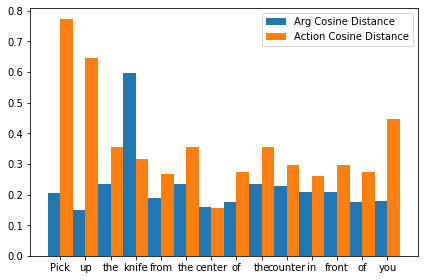

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Align a single instruction to its "output" (its action and arguments)

def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

def pool_word_vectors(vec_arr):
    return torch.stack(vec_arr).max(dim=0)[0]

def avg_word_vectors(vec_arr):
    return torch.stack(vec_arr).mean(dim=0)

def ai2thor_action_to_words(action):
    if action == "GotoLocation":
        return ["go", "to", "location"]
    elif action == "PickupObject":
        return ["pick", "up", "object"]
    elif action == "PutObject":
        return ["put", "object"]

instruction_idx = 1
instruction = instructions[0]
task_desc = instruction['task_desc']
instruction_text = instruction['high_descs'][instruction_idx]
instruction_action = actions[instruction_idx]['discrete_action']['action']
instruction_action_args = actions[instruction_idx]['discrete_action']['args']

print('-' * 30)
print(f"TASK: {instruction['task_desc']}")
for i in range(len(instruction['high_descs'])):
    print(f"INSTRUCTION {i}:{instruction['high_descs'][i]}")
    print(f"\tACTION [{actions[i]['discrete_action']}]")

arg_cosine_sims = []
action_cosine_sims = []
arg_vec = fast_text.get_vecs_by_tokens(instruction_action_args[0].lower())
action_words = ai2thor_action_to_words(actions[instruction_idx]['discrete_action']['action'])
action_vec = avg_word_vectors([fast_text.get_vecs_by_tokens(word.lower()) for word in action_words])
instruction_words = instruction_text.replace('.','')
instruction_words = instruction_words.split()
for word in instruction_words:
    inst_vec = fast_text.get_vecs_by_tokens(word.lower())
    arg_cosine_sims.append(cosine_sim(arg_vec, inst_vec))
    action_cosine_sims.append(cosine_sim(action_vec, inst_vec))

print(instruction_words)
print(instruction_action_args[0])
x = np.arange(len(arg_cosine_sims))
fig, ax = plt.subplots()
args_dist = ax.bar(x - 0.5/2, arg_cosine_sims, 0.5, label="Arg Cosine Distance")
action_dist = ax.bar(x + 0.5/2, action_cosine_sims, 0.5, label="Action Cosine Distance")
ax.set_xticks(x)
ax.set_xticklabels(instruction_words)
fig.tight_layout()
ax.legend()
plt.show()

My current philosophy is that in order for my agent to make the right decisions it needs to know about three things: The graph (The environment), the action, and the action arguments. The current approach to is to format action as selection. Selection of a node in the graph. Selection is done by giving a value to each node based on the node representation (often includes neighbouring features with a GCN), the instruction's action, and the instruction's arguments. Extracting the action and arguments from instruction text is my current challenge. 

In [ ]:
# Instruction Parsing Model A

# References:
# > LSTM based NER model, and other NLP tasks
# > 

class InstructionNet():
    def __init__(self):
        super(InstructionNet, self).__init__()
        pass
    
    def forward(self, x):
        pass